In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

In [2]:
# Load the dataset
df = pd.read_csv('/kaggle/input/customer-segmentation-tutorial-in-python/Mall_Customers.csv')

# Display the first few rows of the dataset
print(df.head())

   CustomerID  Gender  Age  Annual Income (k$)  Spending Score (1-100)
0           1    Male   19                  15                      39
1           2    Male   21                  15                      81
2           3  Female   20                  16                       6
3           4  Female   23                  16                      77
4           5  Female   31                  17                      40


In [3]:
# Dropping the 'CustomerID' column as it's not required for clustering
df = df.drop('CustomerID', axis=1)

# Rename the columns for convenience
df.columns = ['Gender', 'Age', 'Annual Income (k$)', 'Spending Score (1-100)']

# Convert 'Gender' column to numerical values
df['Gender'] = df['Gender'].map({'Male': 0, 'Female': 1})

# Check for missing values
print(df.isnull().sum())

Gender                    0
Age                       0
Annual Income (k$)        0
Spending Score (1-100)    0
dtype: int64


In [4]:
# Feature Scaling
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df)

# Finding the optimal number of clusters using the elbow method
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=42)
    kmeans.fit(df_scaled)
    wcss.append(kmeans.inertia_)

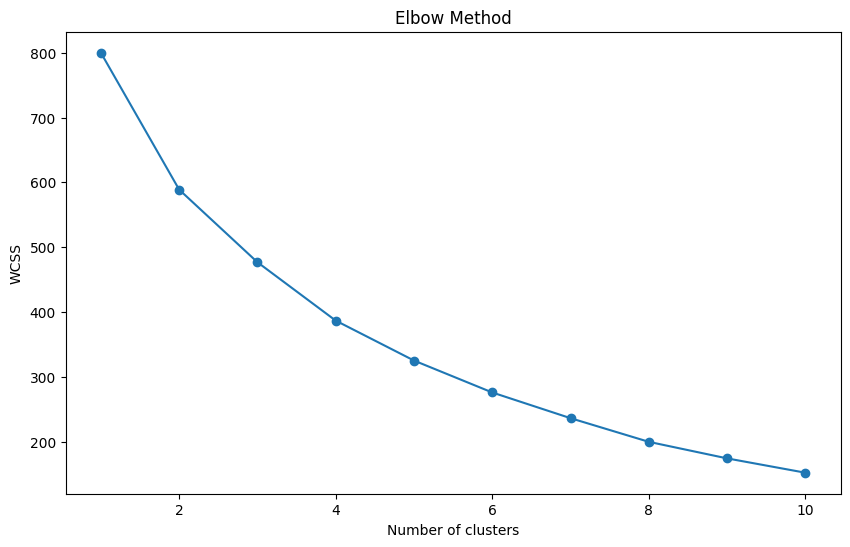

In [5]:
# Plot the elbow graph
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), wcss, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

In [6]:
# From the elbow graph, we can choose the optimal number of clusters
# Here, let's assume it's 5
kmeans = KMeans(n_clusters=5, init='k-means++', max_iter=300, n_init=10, random_state=42)
y_kmeans = kmeans.fit_predict(df_scaled)

# Add the cluster column to the original dataset
df['Cluster'] = y_kmeans

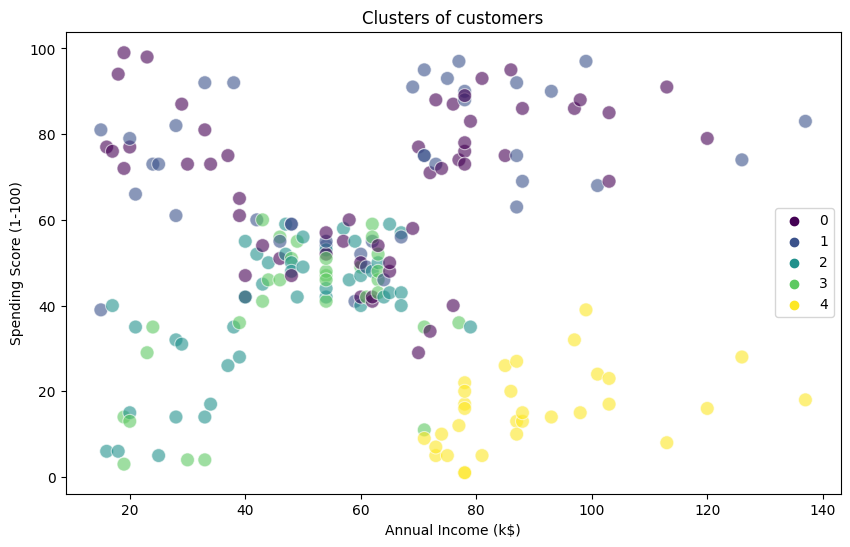

   Gender  Age  Annual Income (k$)  Spending Score (1-100)  Cluster
0       0   19                  15                      39        1
1       0   21                  15                      81        1
2       1   20                  16                       6        2
3       1   23                  16                      77        0
4       1   31                  17                      40        2


In [8]:
# Visualizing the clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Annual Income (k$)', y='Spending Score (1-100)', hue='Cluster', data=df, palette='viridis', s=100, alpha=0.6, edgecolor='w')
plt.title('Clusters of customers')
plt.xlabel('Annual Income (k$)')
plt.ylabel('Spending Score (1-100)')
plt.legend()
plt.show()

# Display the dataset with cluster labels
print(df.head())

Advanced Preprocessing and PCA

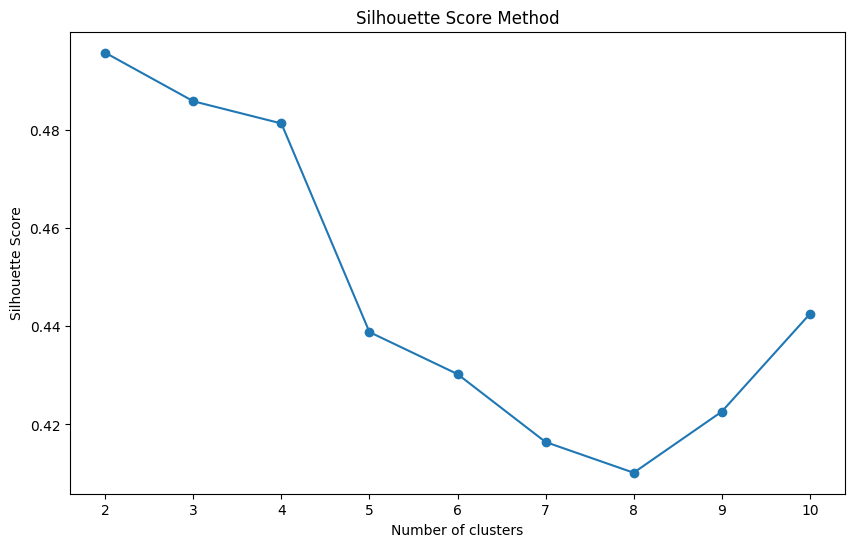

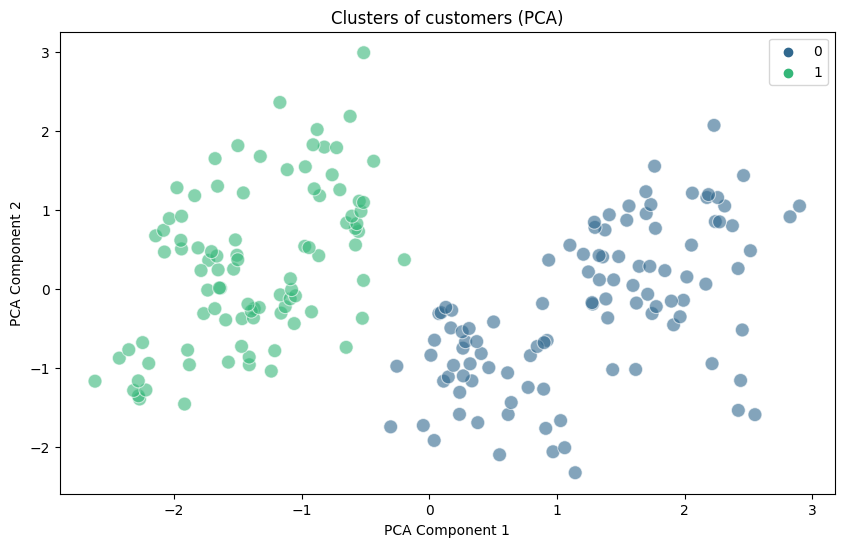

In [9]:
# Import additional libraries
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

# Handle outliers (Optional, here using IQR method)
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR = Q3 - Q1
df = df[~((df < (Q1 - 1.5 * IQR)) | (df > (Q3 + 1.5 * IQR))).any(axis=1)]

# Feature Scaling
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df)

# Apply PCA
pca = PCA(n_components=2)
pca_df = pca.fit_transform(df_scaled)

# Finding the optimal number of clusters using silhouette score
silhouette_scores = []
for i in range(2, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=42)
    kmeans.fit(pca_df)
    score = silhouette_score(pca_df, kmeans.labels_)
    silhouette_scores.append(score)

# Plot silhouette scores
plt.figure(figsize=(10, 6))
plt.plot(range(2, 11), silhouette_scores, marker='o')
plt.title('Silhouette Score Method')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.show()

# Choose optimal clusters based on silhouette score
optimal_clusters = silhouette_scores.index(max(silhouette_scores)) + 2
kmeans = KMeans(n_clusters=optimal_clusters, init='k-means++', max_iter=300, n_init=10, random_state=42)
y_kmeans = kmeans.fit_predict(pca_df)

# Add the cluster column to the original dataset
df['Cluster'] = y_kmeans

# Visualize clusters with PCA components
plt.figure(figsize=(10, 6))
sns.scatterplot(x=pca_df[:, 0], y=pca_df[:, 1], hue=y_kmeans, palette='viridis', s=100, alpha=0.6, edgecolor='w')
plt.title('Clusters of customers (PCA)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend()
plt.show()

Cluster Validation

In [10]:
# Calculate and print cluster validation metrics
sil_score = silhouette_score(pca_df, y_kmeans)
db_score = davies_bouldin_score(pca_df, y_kmeans)
ch_score = calinski_harabasz_score(pca_df, y_kmeans)

print(f'Silhouette Score: {sil_score}')
print(f'Davies-Bouldin Score: {db_score}')
print(f'Calinski-Harabasz Score: {ch_score}')

Silhouette Score: 0.4956561592477877
Davies-Bouldin Score: 0.8098514427909078
Calinski-Harabasz Score: 240.2276475535151


Profiling Clusters

In [11]:
# Profile clusters
for i in range(optimal_clusters):
    cluster = df[df['Cluster'] == i]
    print(f'Cluster {i} Summary:')
    print(cluster.describe())
    print('\n')

Cluster 0 Summary:
           Gender         Age  Annual Income (k$)  Spending Score (1-100)  \
count  104.000000  104.000000          104.000000              104.000000   
mean     0.548077   48.548077           59.144231               32.490385   
std      0.500093   12.013649           24.362321               17.852685   
min      0.000000   19.000000           16.000000                1.000000   
25%      0.000000   40.750000           43.000000               15.000000   
50%      1.000000   48.500000           59.500000               35.500000   
75%      1.000000   57.250000           77.000000               48.000000   
max      1.000000   70.000000          126.000000               60.000000   

       Cluster  
count    104.0  
mean       0.0  
std        0.0  
min        0.0  
25%        0.0  
50%        0.0  
75%        0.0  
max        0.0  


Cluster 1 Summary:
          Gender        Age  Annual Income (k$)  Spending Score (1-100)  \
count  94.000000  94.000000           

Interactive Visualization with Plotly

In [12]:
import plotly.express as px

fig = px.scatter(df, x='Annual Income (k$)', y='Spending Score (1-100)', color='Cluster', title='Clusters of customers', 
                 hover_data=['Gender', 'Age'])
fig.show()
